In [1]:
import os
import sys
import json
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config
import matplotlib.pyplot as plt

ml_dir: /home/lorenzo/Desktop/mimic-2/src/ml | src_dir: /home/lorenzo/Desktop/mimic-2/src | entry_dir: /home/lorenzo/Desktop/mimic-2 




In [2]:
iperf_path = "/home/lorenzo/Desktop/mimic-2/log/iperf"

#  Iperf traces
i_json_2_arms = {
    "att.lte.driving.2016": "att.lte.driving.2016.bootstrapped_ucb.2023.05.17.15.35.04.json",
    "tm.lte.driving": "tm.lte.driving.bootstrapped_ucb.2023.05.17.11.48.42.json",
    "vz.lte.driving": "vz.lte.driving.bootstrapped_ucb.2023.05.17.11.52.09.json"
}

i_json_3_arms = {
    "att.lte.driving.2016": "att.lte.driving.2016.bootstrapped_ucb.2023.05.17.12.16.00.json",
    "tm.lte.driving": "tm.lte.driving.bootstrapped_ucb.2023.05.17.12.19.33.json",
    "vz.lte.driving": "vz.lte.driving.bootstrapped_ucb.2023.05.17.12.27.15.json"
}

In [3]:
# Single protocol iperf metrics

i_cubic_json = {
    "att.lte.driving.2016": "att.lte.driving.2016.cubic.2023.04.22.18.09.38.json",
    "tm.lte.driving": "tm.lte.driving.cubic.2023.04.22.12.35.40.json",
    "vz.lte.driving": "vz.lte.driving.cubic.2023.04.22.12.40.57.json"
}

i_bbr_json = {
    "att.lte.driving.2016": "att.lte.driving.2016.bbr.2023.04.22.12.47.35.json",
    "tm.lte.driving": "tm.lte.driving.bbr.2023.04.22.12.48.38.json",
    "vz.lte.driving": "vz.lte.driving.bbr.2023.04.22.12.52.55.json"
}

i_hybla_json = {
    "att.lte.driving.2016": "att.lte.driving.2016.hybla.2023.04.22.12.59.29.json",
    "tm.lte.driving": "tm.lte.driving.hybla.2023.04.22.13.00.40.json",
    "vz.lte.driving": "vz.lte.driving.hybla.2023.04.22.13.05.53.json"
}

In [5]:
import numpy as np

traces = ["att.lte.driving.2016", "tm.lte.driving", "vz.lte.driving"]
model = "bootstrapped_ucb"
i_json_dict_2 = {}
i_json_dict_3 = {}
i_single_prot_dict = {}

for t in traces:
    i_json_dict_2[t] = read_json_file(os.path.join(iperf_path, i_json_2_arms[t]))

for t in traces:
    i_json_dict_3[t] = read_json_file(os.path.join(iperf_path, i_json_3_arms[t]))

# for iperf
for p in ["cubic", "bbr", "hybla"]:
    if p == "cubic":
        p_json = i_cubic_json
    elif p == "bbr":
        p_json = i_bbr_json
    else:
        p_json = i_hybla_json
    for t in traces:
        i_single_prot_dict[(p, t)] = read_json_file(os.path.join(iperf_path, p_json[t]))

In [4]:
def build_features_per_step(json_obj):
    step_array = {}

    for i, step_logs in enumerate(json_obj):
        step_array[i] = []
        for features_vector in step_logs["observation"]["features"]:
            step_array[i].append(features_vector)
    return step_array

def get_features(feature_vector):
    cwnd_values = []
    rtt_values = []
    thr_values = []
    for step in feature_vector.keys():
        for batch in feature_vector[step]:
            cwnd_values.append(batch[0])
            rtt_values.append(batch[1])
            thr_values.append(batch[8])
    return cwnd_values, rtt_values, thr_values

def get_metrics(config):
    rtts = []
    cwnds = [] 
    s_rate = []
    for intervals in config['intervals']:
        s_rate.append(intervals['streams'][0]['bits_per_second']*10**(-6))
        cwnds.append(intervals['streams'][0]['snd_cwnd'])
        rtts.append(intervals['streams'][0]['rtt']*10**(-3))
    thruput = config["end"]["streams"][0]["receiver"]["bits_per_second"]*10**(-6)
    return thruput, rtts, cwnds, s_rate

10805.106399999999 2.133564481369
594.1141499999998 1.759766178849
11069.214399999999 2.140203802627
7280.550949999996 1.8041340949359999


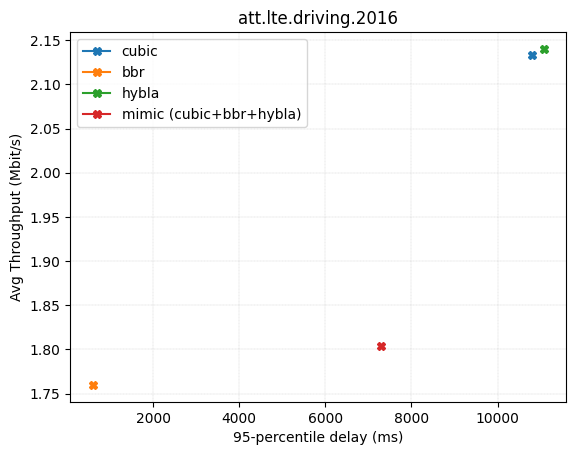

907.8984 29.778377858042
49.24255 23.03897928392
1033.24415 30.252673428810997
680.5364999999996 26.157358330648


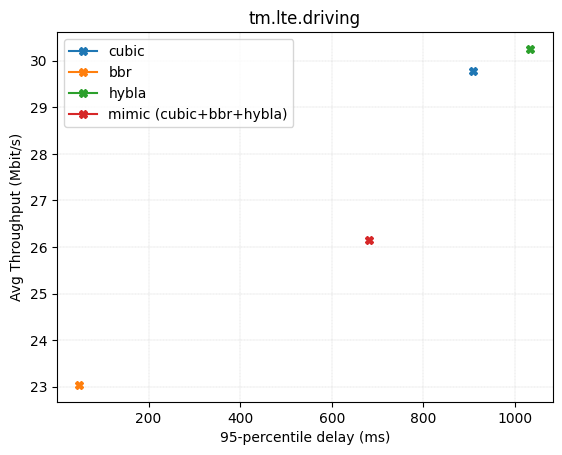

4798.636899999999 7.521605487443
92.95339999999997 6.951583747867999
5931.918499999997 7.616630735748
1822.78925 7.1462363018329995


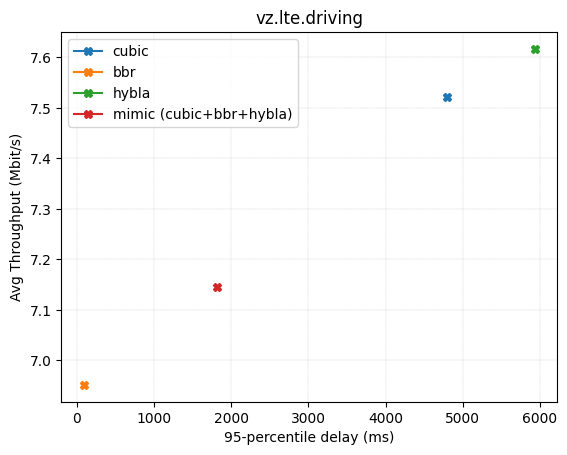

In [7]:
import numpy as np

test_traces = parse_traces_config()
test_traces = [t for t in test_traces['traces'].keys()]

# Get the features batch for each step
save = False
for t in traces:
    # Plot native

    for p in ["cubic", "bbr", "hybla"]:
        thruput, rtts, cwnds, _ = get_metrics(i_single_prot_dict[(p, t)])
        # thr_95_perc = np.mean(thruputs)
        delay_95_perc = np.percentile(rtts, 95)
        print(delay_95_perc, thruput)
        plt.plot(delay_95_perc, thruput, marker='X', label=p)


    # Plot mimic different arms
    for n_arms in [3]:
        
        if n_arms == 2:
            i_dict = i_json_dict_2
        elif n_arms == 3:
            i_dict = i_json_dict_3

        thruput, rtts, cwnds, _ = get_metrics(i_dict[t])
        # thr_95_perc = np.mean(thruputs)
        delay_95_perc = np.percentile(rtts, 95)
        print(delay_95_perc, thruput)

        plt.plot(delay_95_perc, thruput, marker='X', label=f"mimic (cubic+bbr)" if n_arms==2 else "mimic (cubic+bbr+hybla)")

    plt.title(t)
    plt.xlabel('95-percentile delay (ms)')
    plt.ylabel('Avg Throughput (Mbit/s)')
    plt.grid(linestyle='--', linewidth=0.2)
    plt.legend()
    if save:
        filename = f"bootstrapped_ucb.{t}.w_native_protocols.png"
        path = "/home/lorenzo/Desktop/mimic-2/analysis/plots/single_trace_analysis/"
        os.makedirs(path, exist_ok=True)
        plt.savefig(os.path.join(path, f"{filename}"))
    plt.show()